In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import math

# Preliminary notes

* In this document, whenever *distance* is mentioned, it is relative to the diameter of the hit circles of the map. Therefore a distance of 1 is equal to one hit circle diameter, etc.

# Previous object correction

The *previous object correction* is concerned with the three-object movement between: the second-last, the last, and the currently-considered object.

This correction does not apply, if:

* the second last-object does not exist or was a spinner,
* the last and the current object are in the same spot (are on a stack).

Depending on the proportions of durations of the (2nd last -> last) and (last -> current) movements, there are three mutually-exclusive cases to consider:

1. The (last -> current) movement was *longer* than the previous by more than 40% - means the player is *slowing down*.
2. The (last -> current) movement was *shorter* than the previous by more than 40% - means the player is *speeding up*.
3. The two movements were relatively the same duration.

Cases (1) and (2) are additionally discarded if the (2nd last -> last) movement had zero distance travelled.

## Case 1 (slowing down)

In case (1), the correction is dependent on two main factors: the angle between object pairs (`angleCorrection`), or rather its cosine (`movementAngleCosine`), and the (2nd last -> last) distance (`movingness`). The first is demonstrated by the following plots:

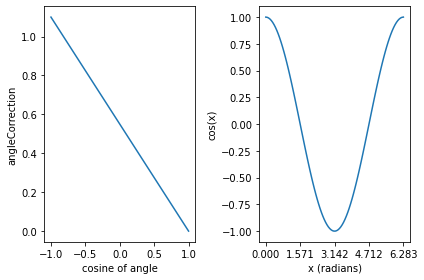

In [8]:
xs = [-1, 1]
ys = [1.1, 0]

fig = plt.figure()

ax1 = fig.add_subplot(121)
ax1.set_ylabel("angleCorrection")
ax1.set_xlabel("cosine of angle")
plt.plot(xs, ys)

xs = np.linspace(0, 2 * math.pi, 100)
ys = np.cos(xs)
ax2 = fig.add_subplot(122)
ax2.set_ylabel("cos(x)")
ax2.set_xlabel("x (radians)")
ax2.set_xticks(np.linspace(0, 2 * math.pi, 5))
plt.plot(xs, ys)

fig.tight_layout()

The cosine has a value of 1 for the zero angle and a value of -1 for the 180 degree angle. Note that the angle whose cosine is being calculated here is anchored at the last object, which is in the middle of the sequence of (2nd last -> last -> current). Therefore an angle of 180 degrees anchored there actually looks like a straight line.

Merging these plots together, to show the direct relationship between the angle and the correction, yields

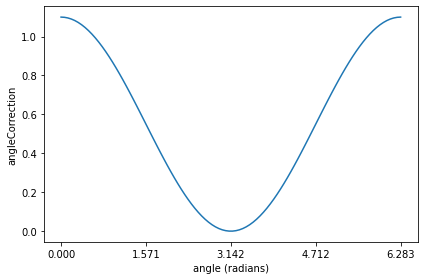

In [7]:
xs = np.linspace(0, 2 * math.pi, 100)
ys = (np.cos(xs) + 1) / 2 * 1.1

fig = plt.figure()

ax = fig.add_subplot()
ax.set_xlabel('angle (radians)')
ax.set_ylabel('angleCorrection')
ax.set_xticks(np.linspace(0, 2 * math.pi, 5))
plt.plot(xs, ys)

fig.tight_layout()

This means that in regards of this multiplier, going back in the direction the player just moved in results in maximum amplification of this factor to the tune of 1.1 times, while continuing in a straight line results in its nullification.

The second factor is given by the following plot:

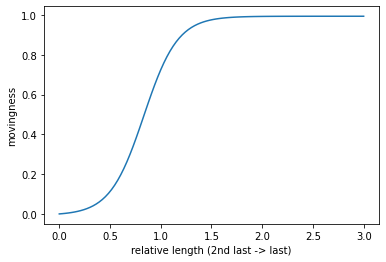

In [3]:
def logistic(xs):
    return 1 / (np.exp(-xs) + 1)

xs = np.linspace(0, 3, 100)
ys = logistic(xs * 6 - 5) - logistic(-5)

fig = plt.figure()
ax = fig.add_subplot()
ax.set_ylabel("movingness")
ax.set_xlabel("relative length (2nd last -> last)")
plt.plot(xs, ys)

The resulting total correction in this case is given by `1.5 * movingness * angleCorrection`.

What this means in practice:

* The range of this correction is \[0, 1.5 * 1.1 = 1.65\]
* The more straight-line the movement between the three objects is, the closer to zero the correction is
* Shorter movements result in a smaller value
* Longer movements result in a bigger value

## Case 2 (speeding up)

This case is also dependent on the cosine of the movement angle and the relative length of (2nd last -> last), multiplied by the time ratio. The former factor is given by a simple

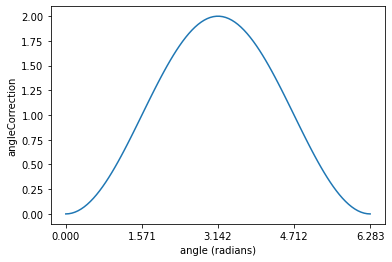

In [18]:
xs = np.linspace(0, 2 * math.pi, 100)
ys = 1 - np.cos(xs)

fig = plt.figure()
ax = fig.add_subplot()
ax.set_xlabel('angle (radians)')
ax.set_ylabel('angleCorrection')
ax.set_xticks(np.linspace(0, 2 * math.pi, 5))
plt.plot(xs, ys)

while the latter is computed as

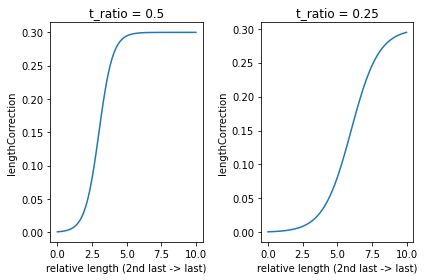

In [16]:
xs = np.linspace(0, 10, 100)
y1s = logistic((xs * 0.5 - 1.5) * 4) * 0.3
y2s = logistic((xs * 0.25 - 1.5) * 4) * 0.3

fig = plt.figure()

ax1 = fig.add_subplot(121)
ax1.set_title('t_ratio = 0.5')
ax1.set_xlabel('relative length (2nd last -> last)')
ax1.set_ylabel('lengthCorrection')
plt.plot(xs, y1s)

ax2 = fig.add_subplot(122)
ax2.set_title('t_ratio = 0.25')
ax2.set_xlabel('relative length (2nd last -> last)')
ax2.set_ylabel('lengthCorrection')
plt.plot(xs, y2s)

fig.tight_layout()

Conclusions:

- This correction is bounded by \[0, 0.6\]
- This correction is smallest when (2nd last -> last) and (last -> current) movements occur in opposite directions (cancel each other out)
- This correction is largest when movements occur in a straight line
- The length correction scales with the ratio of speed-up in the movement (the logistic factor peaks faster if the speed-up is more radical).

## Case 3 (pace relatively constant)

This case is by far the most complex. First off, the (2nd last -> last) movement is rescaled length-wise by the time ratio between the two movements, as if (2nd last -> last) and (last -> current) took roughly the same time. This is done in order so that they are comparable time-wise.

Then, a coordinate transformation is performed, such that the last object resides in the Cartesian coordinate origin (0, 0), and the current object is at (lastToCurrent.RelativeLength, 0). The second-last object is appropriately rotated/rescaled to fit this.

The following graphs contain crude approximations of how the 2D slices of the correction functions look like:

In [82]:
flow_neg2_r1s = [0.2, 0.6, 1, 1.3, 1.7, 2.1]
flow_neg2_r2s = [0.1, 0.6, 1, 1.3, 1.8, 3]
angles = np.linspace(0, math.pi, 5)

flow_neg2_vs = \
    [ \
        [ \
            [ 0.45, 0.44, 0.42, 0.39, 0.39 ], \
            [ 0.89, 0.87, 0.80, 0.72, 0.67 ], \
            [ 0.99, 0.99, 0.98, 0.97, 0.96 ], \
            [ 1.00, 1.00, 1.00, 1.00, 1.00 ], \
            [ 1.00, 1.00, 1.00, 1.00, 1.00 ], \
            [ 1.00, 1.00, 1.00, 1.00, 1.00 ] \
        ], \
        [ \
            [ 0.27, 0.26, 0.23, 0.20, 0.19 ], \
            [ 0.75, 0.68, 0.44, 0.26, 0.20 ], \
            [ 0.97, 0.94, 0.83, 0.59, 0.46 ], \
            [ 0.99, 0.99, 0.96, 0.86, 0.77 ], \
            [ 1.00, 1.00, 1.00, 0.99, 0.98 ], \
            [ 1.00, 1.00, 1.00, 1.00, 1.00 ] \
        ], \
        [ \
            [ 0.16, 0.16, 0.14, 0.13, 0.13 ], \
            [ 0.37, 0.31, 0.19, 0.13, 0.11 ], \
            [ 0.65, 0.55, 0.29, 0.20, 0.17 ], \
            [ 0.83, 0.76, 0.51, 0.34, 0.28 ], \
            [ 0.96, 0.94, 0.84, 0.69, 0.61 ], \
            [ 1.00, 1.00, 1.00, 0.99, 0.99 ] \
        ], \
        [ \
            [ 0.29, 0.28, 0.26, 0.23, 0.23 ], \
            [ 0.56, 0.48, 0.31, 0.19, 0.16 ], \
            [ 0.80, 0.71, 0.41, 0.24, 0.18 ], \
            [ 0.91, 0.85, 0.61, 0.34, 0.25 ], \
            [ 0.98, 0.96, 0.87, 0.63, 0.49 ], \
            [ 1.00, 1.00, 1.00, 0.99, 0.97 ] \
        ], \
        [ \
            [ 0.39, 0.38, 0.35, 0.32, 0.31 ], \
            [ 0.66, 0.59, 0.39, 0.24, 0.20 ], \
            [ 0.85, 0.78, 0.47, 0.24, 0.17 ], \
            [ 0.93, 0.88, 0.62, 0.27, 0.18 ], \
            [ 0.98, 0.97, 0.84, 0.45, 0.27 ], \
            [ 1.00, 1.00, 0.99, 0.94, 0.85 ] \
        ], \
        [ \
            [ 0.94, 0.94, 0.93, 0.92, 0.92 ], \
            [ 0.98, 0.97, 0.94, 0.89, 0.86 ], \
            [ 0.99, 0.99, 0.96, 0.87, 0.82 ], \
            [ 1.00, 0.99, 0.97, 0.87, 0.81 ], \
            [ 1.00, 1.00, 0.99, 0.90, 0.84 ], \
            [ 1.00, 1.00, 1.00, 0.99, 0.98 ] \
        ] \
    ]

In [110]:
def plot_correction_rough(r1s, r2s, thetas, vs, index, title):
    rr, tt = np.meshgrid(r2s, thetas)
    fig, ax = plt.subplots(subplot_kw=dict(projection='polar'), figsize=(12,6))
    contour = ax.contourf(tt, rr, np.transpose(vs[index]), vmin=0, vmax=1)
    fig.colorbar(contour, ticks=np.linspace(0, 1, 11))
    ax.set_title(title + str(r1s[index]))
    ax.set_thetamin(0)
    ax.set_thetamax(180)
    fig.tight_layout()

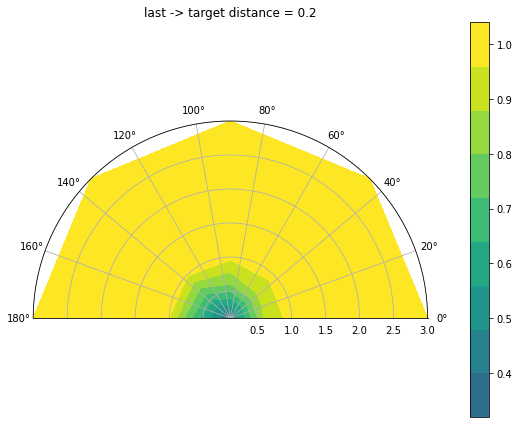

In [111]:
plot_correction_rough(flow_neg2_r1s, flow_neg2_r2s, angles, flow_neg2_vs, 0, 'last -> target distance = ')

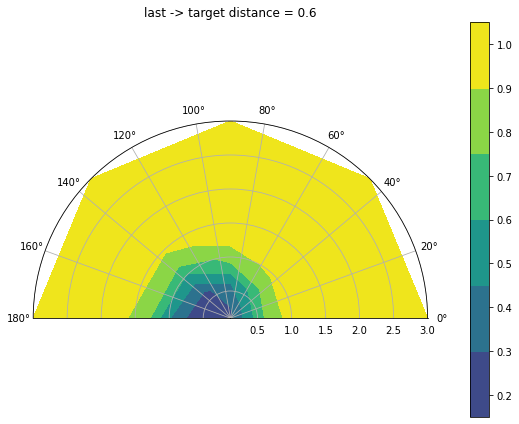

In [113]:
plot_correction_rough(flow_neg2_r1s, flow_neg2_r2s, angles, flow_neg2_vs, 1, 'last -> target distance = ')

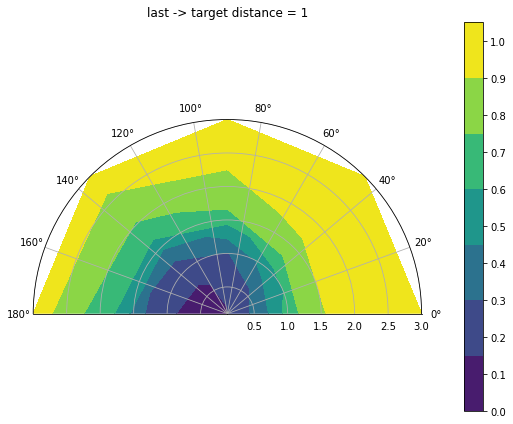

In [114]:
plot_correction_rough(flow_neg2_r1s, flow_neg2_r2s, angles, flow_neg2_vs, 2, 'last -> target distance = ')

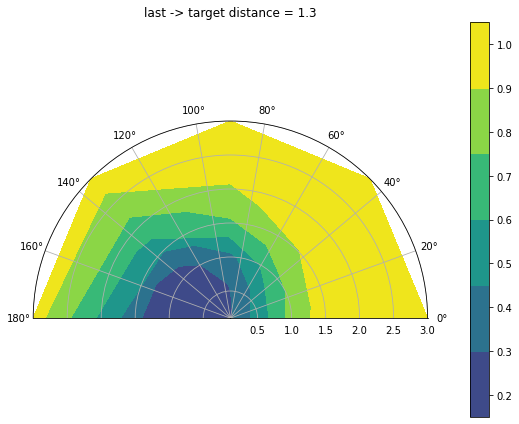

In [115]:
plot_correction_rough(flow_neg2_r1s, flow_neg2_r2s, angles, flow_neg2_vs, 3, 'last -> target distance = ')

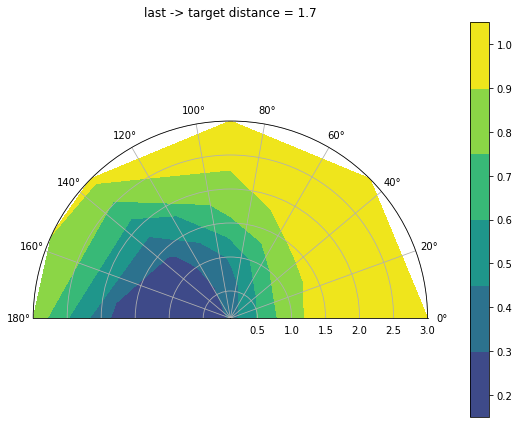

In [116]:
plot_correction_rough(flow_neg2_r1s, flow_neg2_r2s, angles, flow_neg2_vs, 4, 'last -> target distance = ')